## Mini projet 1 : Qui a peint ce tableau?

### Introduction


Le but de ce premier mini-projet est de construire (et entraîner!) un réseau à même de répondre au
challenge artchallenge.ru – Qui a peint ce tableau ?

Le but de ce premier mini-projet est de construire (et entraîner) un réseau (CNN) capable de répondre au challenge artchallenge.ru – "Qui a peint ce tableau ?".
**Un réseau de neurones convolutifs (CNN, pour Convolutional Neural Network)** est un modèle d’apprentissage automatique spécifiquement conçu pour traiter des données organisées sous forme de grilles, comme les images. Il s’appuie sur des couches convolutives pour extraire automatiquement des caractéristiques pertinentes, telles que les contours ou les textures, en appliquant des filtres sur les données d’entrée. Ces réseaux intègrent également des couches de sous-échantillonnage (pooling) pour réduire la taille des données tout en préservant les informations essentielles, ainsi que des couches entièrement connectées pour la prise de décision finale.

### Problématique

L'objectif de ce mini-projet est de comprendre comment concevoir et entraîner un réseau de neurones performant capable d’identifier l’artiste d’une peinture donnée, en exploitant les caractéristiques visuelles des œuvres et les données disponibles tout en tenant compte des variations de résolution et des styles artistiques divers ?

### Dataset

Nous utilisons un dataset extrait du site ci-dessous:
https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge
Ainsi qu'un csv contenant des informations sur chaque peintre

### Importation des librairies

In [66]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

2.16.2
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [67]:
# Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Importation des données sur les artistes

In [68]:
#chargement des données sur python
artists = pd.read_csv("artists.csv", delimiter=',')
#afficher les 7 premières lignes
artists.head(7)

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90


In [69]:
artists.describe()

,id,paintings
count,50.00000,50.000000
mean,24.50000,168.920000
std,14.57738,157.451105
min,0.00000,24.000000
25%,12.25000,81.000000
50%,24.50000,123.000000
75%,36.75000,191.750000
max,49.00000,877.000000


In [70]:
artists.describe().iloc[0,0]

50.0

*  Il y a 50 artistes au total

In [71]:
artists.dtypes

id              int64
name           object
years          object
genre          object
nationality    object
bio            object
wikipedia      object
paintings       int64
dtype: object

In [72]:
artists['id'] = artists['id'].astype('category')

In [73]:
total_missing = artists.isna().sum()
print(total_missing)

id             0
name           0
years          0
genre          0
nationality    0
bio            0
wikipedia      0
paintings      0
dtype: int64


* Il n'y a pas de valeur manquante donc pas besoin de supprimer de colonne ou ligne, ou de faire un nettoyage.

### Analyse exploratoire des données 

#### Données CSV :

In [74]:
#Statistiques descriptives pour la colonne 'paintings'
paintings_desc = artists['paintings'].describe()
print(paintings_desc)

count     50.000000
mean     168.920000
std      157.451105
min       24.000000
25%       81.000000
50%      123.000000
75%      191.750000
max      877.000000
Name: paintings, dtype: float64


* Ici on veut voir si les données sont homogènes. On voit qu'on a en moyenne 168 tableaux par artiste, avec certains artistes ayant seulement 24 tableaux, et d'autres pouvant en avoir jusqu'à 877. Il y a une énorme différence. Si c'est possible dans le projet, il serait intéressant de faire de la data augmentation pour homogénéiser les données.

In [75]:
artists['years'] = artists['years'].str.replace('–', '-')
artists[['birth_year', 'death_year']] = artists['years'].str.split(' - ', expand=True).astype(int)
artists['age_at_death'] = artists['death_year'] - artists['birth_year']

In [76]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings,birth_year,death_year,age_at_death
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193,1884,1920,36
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88,1866,1944,78
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70,1886,1957,71
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73,1840,1926,86
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194,1898,1967,69


In [77]:
#Statistiques descriptives pour la colonne 'age at death'
age_at_death_desc = artists['age_at_death'].describe()
print(age_at_death_desc)

count    50.00000
mean     64.78000
std      16.74087
min      32.00000
25%      55.25000
50%      65.50000
75%      77.50000
max      98.00000
Name: age_at_death, dtype: float64


* Ça ne paraît pas super utile à savoir, mais la moyenne d'âge des artistes à leur mort est de 64 ans, avec certains se rapprochant de la centaine. La plupart des artistes dans cette liste ont vécu pas mal de temps.

In [78]:
# Diviser la colonne 'genre' par les virgules, puis créer des lignes individuelles pour chaque genre
genre_exploded = artists.assign(genre=artists['genre'].str.split(',')).explode('genre')
genre_counts = genre_exploded['genre'].value_counts()
genre_exploded


,id,name,years,genre,nationality,bio,wikipedia,paintings,birth_year,death_year,age_at_death
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193,1884,1920,36
1,1,Vasiliy Kandinskiy,1866 - 1944,Expressionism,Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88,1866,1944,78
1,1,Vasiliy Kandinskiy,1866 - 1944,Abstractionism,Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88,1866,1944,78
2,2,Diego Rivera,1886 - 1957,Social Realism,Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70,1886,1957,71
2,2,Diego Rivera,1886 - 1957,Muralism,Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70,1886,1957,71
...,...,...,...,...,...,...,...,...,...,...,...
46,46,Paul Gauguin,1848 - 1903,Symbolism,French,"Eugène Henri Paul Gauguin (UK: , US: ; French:...",http://en.wikipedia.org/wiki/Paul_Gauguin,311,1848,1903,55
46,46,Paul Gauguin,1848 - 1903,Post-Impressionism,French,"Eugène Henri Paul Gauguin (UK: , US: ; French:...",http://en.wikipedia.org/wiki/Paul_Gauguin,311,1848,1903,55
47,47,Raphael,1483 - 1520,High Renaissance,Italian,Raffaello Sanzio da Urbino (Italian: [raffaˈɛl...,https://en.wikipedia.org/wiki/Raphael,109,1483,1520,37
48,48,Michelangelo,1475 - 1564,High Renaissance,Italian,Michelangelo di Lodovico Buonarroti Simoni or ...,https://en.wikipedia.org/wiki/Michelangelo,49,1475,1564,89


In [79]:
nationality_counts = artists['nationality'].value_counts()
print(nationality_counts)

nationality
French                      13
Italian                      8
Spanish                      5
Russian                      4
Dutch                        4
Flemish                      3
Mexican                      2
American                     2
Belgian                      1
Austrian                     1
Spanish,Greek                1
German                       1
French,British               1
French,Jewish,Belarusian     1
British                      1
Norwegian                    1
German,Swiss                 1
Name: count, dtype: int64


* On peut voir que la grande majorité des artistes sont européens et très peu d'autres ethnies, donc on va sûrement retrouver des styles assez similaires niveau peinture/tableau/style. ça sera sûrement plus difficile pour l'algo de différencier entre les artistes... Alors que si on avait des styles très différents avec des artistes venant d'Asie ou encore d'Afrique, comme on retrouverait des différences dans les styles qui sont beaucoup plus marqués, l'algo aurait une plus grande facilité à différencier les artistes par leur tableau

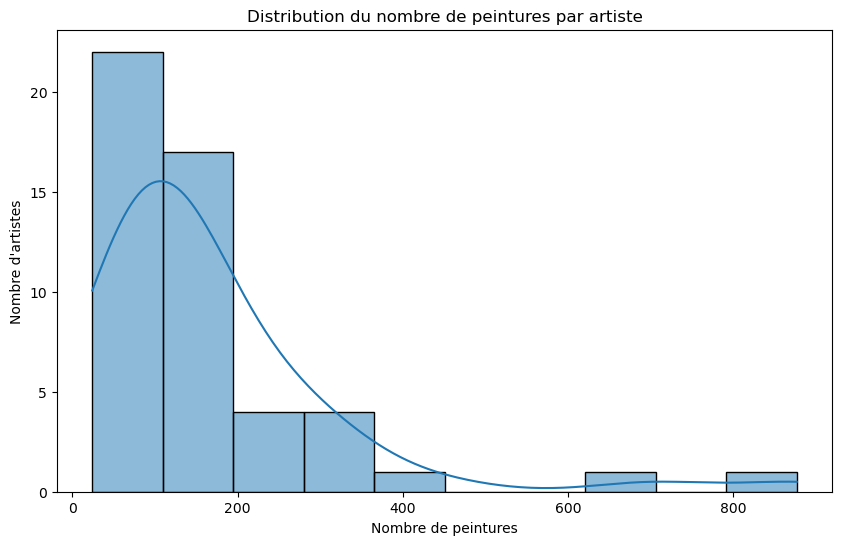

In [80]:
# Plot for paintings distribution
plt.figure(figsize=(10, 6))
sns.histplot(artists['paintings'], bins=10, kde=True)
plt.title("Distribution du nombre de peintures par artiste")
plt.xlabel("Nombre de peintures")
plt.ylabel("Nombre d'artistes")
plt.show()


* On remarque que la grande majorité des artistes ont entre 20 et 200 tableaux et que quelques artistes en possèdent beaucoup plus (200 ou plus), donc peut-être qu'homogénéiser le nombre de tableaux pour tous les artistes n'est pas la meilleure idée. C'est déjà assez homogène avec quelques cas extrêmes. On pourrait soit laisser ça comme ça, ou bien on peu reduire le nombre de tableau pour les artistes qui en ont beaucoup trop. 

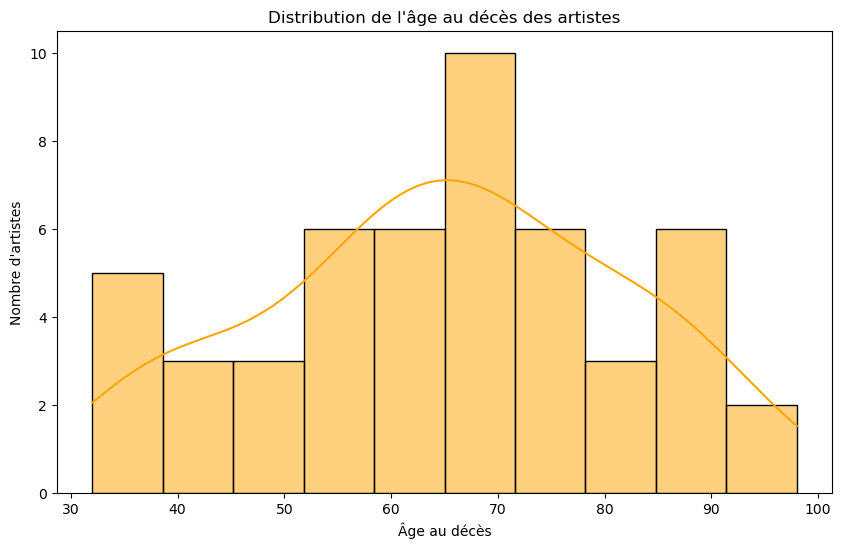

In [81]:
# Plot for age at death distribution
plt.figure(figsize=(10, 6))
sns.histplot(artists['age_at_death'].dropna(), bins=10, kde=True, color='orange')
plt.title("Distribution de l'âge au décès des artistes")
plt.xlabel("Âge au décès")
plt.ylabel("Nombre d'artistes")
plt.show()

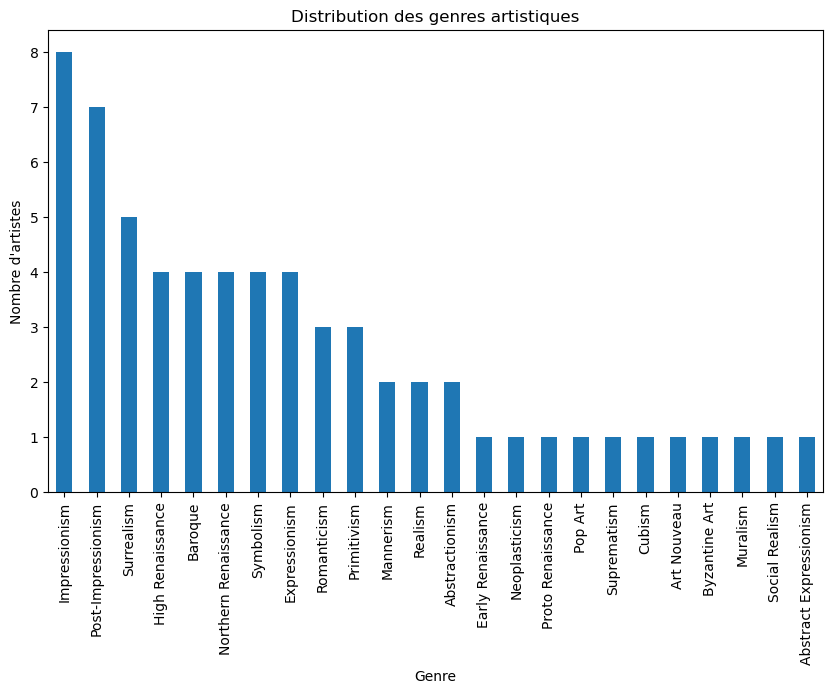

In [82]:
# Plot for genre distribution
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title("Distribution des genres artistiques")
plt.xlabel("Genre")
plt.ylabel("Nombre d'artistes")
plt.show()

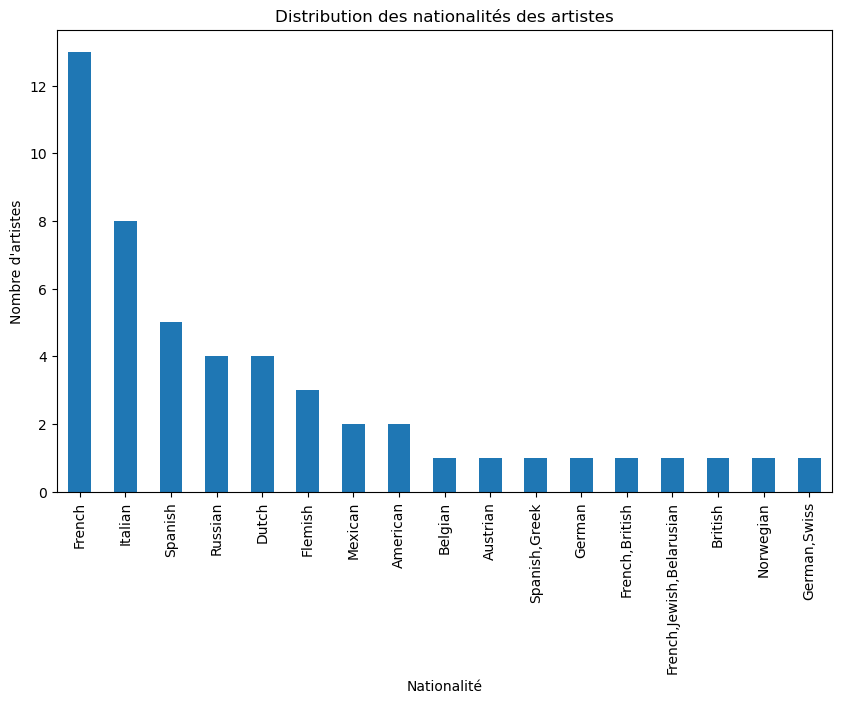

In [83]:
# Plot for nationality distribution
plt.figure(figsize=(10, 6))
nationality_counts.plot(kind='bar')
plt.title("Distribution des nationalités des artistes")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.show()

#### Organisation des données LQ :

Les données Low Quality ne sont pas organisées et séparrées selon les peintres comme dans le cas des données High Quality. 

La cellule ci-dessous permet d'organiser les données LQ dans un nouveau dossier contenant deux dossiers Train et Test. Les dossiers Train et Test contiennet les images des oeuvres d'art réparties selon le nom de l'artiste.

On a choisi un ratio de **80%** pour les données d'entrainement et **20%** pour les données Test.

In [84]:
import os
import shutil
import random

# Dossier contenant les images d'origine
image_folder = '/Users/macbookpro/Desktop/HDDL/CNN/images_lq'

# Dossiers de sortie pour l'entraînement et la validation
train_folder = '/Users/macbookpro/Desktop/HDDL/CNN/image_LQ/Train'
val_folder = '/Users/macbookpro/Desktop/HDDL/CNN/image_LQ/Test'

# Pourcentage de données pour l'entraînement
train_ratio = 0.8

# Créer les dossiers d'entraînement et de validation s'ils n'existent pas
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Organiser les images par artiste
artist_images = {}
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        # Extraire le nom complet de l'artiste en ignorant l'ID final
        artist_name = '_'.join(filename.split('_')[:-1])  # Nom complet avant le dernier underscore
        if artist_name not in artist_images:
            artist_images[artist_name] = []
        artist_images[artist_name].append(filename)

# Diviser les images et les copier dans les dossiers appropriés
for artist, images in artist_images.items():
    # Créer des sous-dossiers pour chaque artiste dans train et val
    os.makedirs(os.path.join(train_folder, artist), exist_ok=True)
    os.makedirs(os.path.join(val_folder, artist), exist_ok=True)
    
    # Mélanger les images pour une distribution aléatoire
    random.shuffle(images)
    
    # Calculer le nombre d'images pour l'entraînement et la validation
    train_count = int(len(images) * train_ratio)
    
    # Copier les images dans le dossier d'entraînement
    for image in images[:train_count]:
        src = os.path.join(image_folder, image)
        dest = os.path.join(train_folder, artist, image)
        shutil.copyfile(src, dest)
    
    # Copier les images dans le dossier de validation
    for image in images[train_count:]:
        src = os.path.join(image_folder, image)
        dest = os.path.join(val_folder, artist, image)
        shutil.copyfile(src, dest)

print("Images copiées dans les dossiers d'entraînement et de validation.")


Images copiées dans les dossiers d'entraînement et de validation.


### Division des échantillons :

On va diviser notre échantillon images_hq en train et test.

In [87]:
TRAIN_DIR='/Users/macbookpro/Desktop/HDDL/CNN/image_LQ/Train'
TEST_DIR='/Users/macbookpro/Desktop/HDDL/CNN/image_LQ/Test'

In [88]:
from keras.preprocessing.image import load_img
# Dossier contenant les sous-dossiers d'images
train_folder = TRAIN_DIR

# Variables pour stocker les largeurs et hauteurs
widths = []
heights = []

# Parcourir chaque sous-dossier (chaque artiste) dans le dossier train
for artist_folder in os.listdir(train_folder):
    artist_path = os.path.join(train_folder, artist_folder)
    
    # Vérifier que c'est bien un dossier
    if os.path.isdir(artist_path):
        # Parcourir chaque image dans le sous-dossier
        for filename in os.listdir(artist_path):
            if filename.endswith('.jpg'):
                # Charger l'image
                img = load_img(os.path.join(artist_path, filename))
                
                # Obtenir la taille de l'image
                width, height = img.size
                widths.append(width)
                heights.append(height)

# Calculer la largeur et hauteur moyennes
mean_width = np.mean(widths)
mean_height = np.mean(heights)
min_width, min_height=min(widths),min(heights)

print(f"Largeur moyenne : {mean_width}")
print(f"Hauteur moyenne : {mean_height}")
print(f"Largeur minimale : {min_width}")
print(f"Hauteur minimale : {min_height}")


Largeur moyenne : 545.7836760124611
Hauteur moyenne : 575.6078504672897
Largeur minimale : 122
Hauteur minimale : 136


In [ ]:
# Dossier contenant les sous-dossiers d'images
train_folder = TEST_DIR

# Variables pour stocker les largeurs et hauteurs
widths = []
heights = []

# Parcourir chaque sous-dossier (chaque artiste) dans le dossier train
for artist_folder in os.listdir(train_folder):
    artist_path = os.path.join(train_folder, artist_folder)
    
    # Vérifier que c'est bien un dossier
    if os.path.isdir(artist_path):
        # Parcourir chaque image dans le sous-dossier
        for filename in os.listdir(artist_path):
            if filename.endswith('.jpg'):
                # Charger l'image
                img = load_img(os.path.join(artist_path, filename))
                
                # Obtenir la taille de l'image
                width, height = img.size
                widths.append(width)
                heights.append(height)

# Calculer la largeur et hauteur moyennes
mean_width = np.mean(widths)
mean_height = np.mean(heights)
min_width, min_height=min(widths),min(heights)

print(f"Largeur moyenne : {mean_width}")
print(f"Hauteur moyenne : {mean_height}")
print(f"Largeur minimale : {min_width}")
print(f"Hauteur minimale : {min_height}")


Largeur moyenne : 552.8978748524203
Hauteur moyenne : 579.3789846517119
Largeur minimale : 125
Hauteur minimale : 140


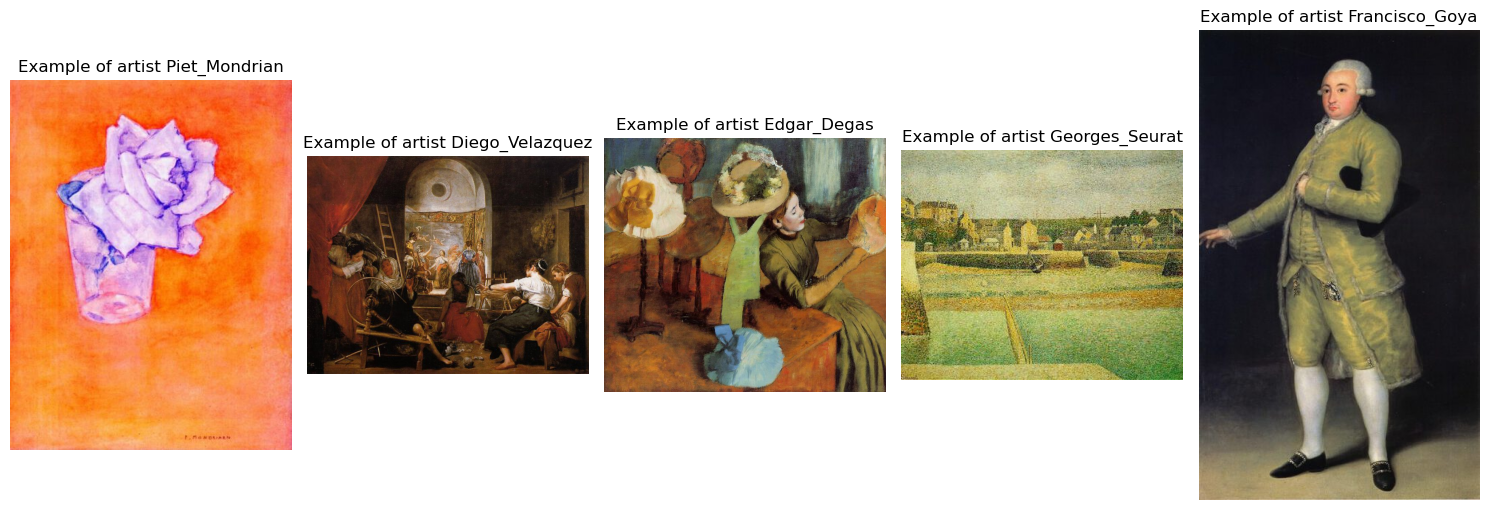

In [ ]:
# Nombre d'artistes à afficher
num_artists = 5

# Récupérer les dossiers d'artistes dans le dossier train
artists = os.listdir(TRAIN_DIR)[:num_artists]

# Créer la figure
fig, axes = plt.subplots(1, num_artists, figsize=(15, 5))

for ii, artist in enumerate(artists):
    dir = os.path.join(TRAIN_DIR, artist)
    img = tf.keras.preprocessing.image.load_img(os.path.join(dir, os.listdir(dir)[0]))
    
    # Afficher l'image dans le sous-plot
    axes[ii].imshow(img)
    axes[ii].set_title(f'Example of artist {artist}')
    axes[ii].axis('off')  # Pour masquer les axes

plt.tight_layout()
plt.show()


* On choisit de prendre des batchs de 32 pour nos train et test datasets et que les images soient toutes de taille 256x256x3 (car ce sont des images en couleurs)

In [33]:
def train_val_datasets():
    train_dataset=tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        batch_size=32,
        image_size=(256,256),
        label_mode = 'categorical'
    )
    test_dataset=tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        batch_size=32,
        image_size=(256,256),
        label_mode = 'categorical'
    )
    return train_dataset,test_dataset

In [34]:
train_dataset,test_dataset=train_val_datasets()
print(f'images of train dataset have shape{train_dataset.element_spec[0].shape}')
print(f'images of train dataset have shape{train_dataset.element_spec[1].shape}')
print(f'images of train dataset have shape{test_dataset.element_spec[0].shape}')
print(f'images of train dataset have shape{test_dataset.element_spec[1].shape}')

Found 6661 files belonging to 50 classes.
Found 1694 files belonging to 50 classes.
images of train dataset have shape(None, 256, 256, 3)
images of train dataset have shape(None, 50)
images of train dataset have shape(None, 256, 256, 3)
images of train dataset have shape(None, 50)


* 6661 image pour le train et 1694 pour le test. 

La fonction ci-dessous **'plotloss_acc'** va nous permettre de voir le training accuracy et validation accuracy au cours des epochs et pouvoir comparer leur évolution. 

In [36]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

### Image classification with Multi Layer Perceptron model.¶

* Voici un modele CNN avec 2 couches de convolutions, une image de taille 256x256x3 en entrée et une sortie de taille 50 (50 classes, i.e 1 classe par artiste)


* C'est un modèle qu'on fait nous même sans utiliser de modèle pré-entrainé pour commencer

In [37]:
def create_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(256, 256, 3)),  
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(50, activation='softmax')  # 50 classes pour 50 artistes
    ])
    model.compile(loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy'])
    return model



In [38]:
model=create_model()
print(f"Input_shape{model.input_shape}")
print(f"Output_shape{model.output_shape}")

Input_shape(None, 256, 256, 3)
Output_shape(None, 50)


In [39]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │   251,920,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,022,194 (961.39 MB)

 Trainable params: 252,022,194 (961.39 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_multilayer=model.fit(train_dataset,
                  epochs=10,
                  validation_data=test_dataset)

Epoch 1/10


2024-12-17 18:30:51.353934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 21/209 ━━━━━━━━━━━━━━━━━━━━ 1:53 603ms/step - accuracy: 0.0242 - loss: nan            

KeyboardInterrupt: 

* Il faut impérativement utiliser des modèles pré-entrainés dans le cadre de ce projet.
* Un modèle MLP ne nous permettra jamais d'effectuer la tâche de classification vu la complexité des données.

### ResNet 50

Cette fois on va utiliser le modèle pré-entrainé resNet50 qui permet d'avoir une balance entre précision et rapidité d'entrainement.

In [43]:
base_model_res = tf.keras.applications.ResNet50(input_shape=(256, 256, 3),
                                            include_top=False,
                                            weights='imagenet')
base_model_res.trainable = False  # Geler les couches du modèle de base

On modifie le modèle pour qu'on aie 50 classes en sortie.

In [ ]:
# Créer le modèle final
model_res = tf.keras.models.Sequential([
    base_model_res,
    tf.keras.layers.GlobalAveragePooling2D(),  # Pooling global pour réduire les dimensions
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='softmax')  # 50 classes pour les 50 artistes
])

# Compiler le modèle
model_res.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',  # Utiliser cette perte pour des labels entiers 
              metrics=['accuracy'])

# Afficher le résumé du modèle
model_res.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,662,450 (94.08 MB)

 Trainable params: 1,074,738 (4.10 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [45]:
history_res = model_res.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=10,
                    batch_size=16,
                    verbose=1)

Epoch 1/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 59s 263ms/step - accuracy: 0.2484 - loss: 3.1928 - val_accuracy: 0.5579 - val_loss: 1.7544
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.5117 - loss: 1.8194 - val_accuracy: 0.6187 - val_loss: 1.4429
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 51s 244ms/step - accuracy: 0.5846 - loss: 1.4741 - val_accuracy: 0.6547 - val_loss: 1.3169
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 51s 246ms/step - accuracy: 0.6425 - loss: 1.2495 - val_accuracy: 0.6564 - val_loss: 1.2615
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 53s 253ms/step - accuracy: 0.6724 - loss: 1.1001 - val_accuracy: 0.6741 - val_loss: 1.2019
Epoch 6/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 52s 249ms/step - accuracy: 0.7119 - loss: 0.9826 - val_accuracy: 0.6824 - val_loss: 1.1815
Epoch 7/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 52s 248ms/step - accuracy: 0.7328 - loss: 0.8718 - val_accuracy: 0.6919 - val_loss: 1.1344
Epoch 8/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 51s 244ms/step - accuracy: 0.7521 - loss: 0

In [46]:
loss, accuracy = model_res.evaluate(test_dataset)

print(f"Accuracy sur le test set : {accuracy:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.7084 - loss: 1.1152
Accuracy sur le test set : 0.7048


On obtient une accuracy d'environ **70%** avec le Resnet50 sur les données Test.

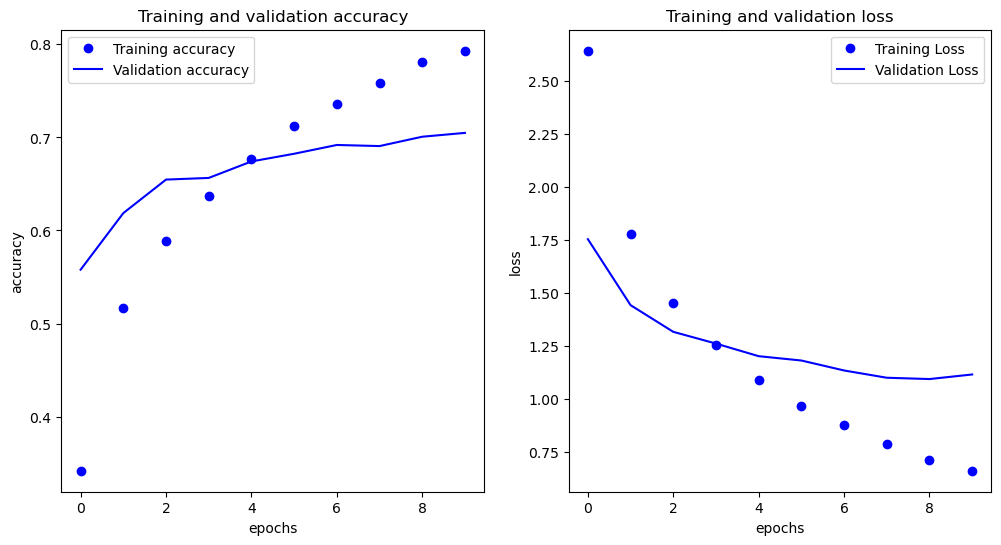

In [61]:
plot_loss_acc(history_res)

## Inception V3

On reproduit la même chose qu'on a fait avec ResNet50 pour d'autre modèle dont **Inception V3**.

In [47]:
base_model_incept = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model_incept.trainable = False

In [48]:
model_incept = tf.keras.models.Sequential([
    base_model_incept,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='softmax')
])

In [49]:
model_incept.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_incept.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,877,522 (87.27 MB)

 Trainable params: 1,074,738 (4.10 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [50]:
# Entraîner le modèle
history_incept = model_incept.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=10,                    # Nombre d'époques d'entraînement
                    batch_size=32,                # Taille des lots
                    verbose=1)

Epoch 1/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 50s 213ms/step - accuracy: 0.0693 - loss: 13.6118 - val_accuracy: 0.1051 - val_loss: 3.8036
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.0985 - loss: 3.8428 - val_accuracy: 0.1057 - val_loss: 3.7776
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 179ms/step - accuracy: 0.1057 - loss: 3.7874 - val_accuracy: 0.1145 - val_loss: 3.7290
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.1058 - loss: 3.7357 - val_accuracy: 0.1039 - val_loss: 3.7170
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 44s 211ms/step - accuracy: 0.0992 - loss: 3.7077 - val_accuracy: 0.1045 - val_loss: 3.6826
Epoch 6/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 44s 212ms/step - accuracy: 0.1018 - loss: 3.6767 - val_accuracy: 0.1057 - val_loss: 3.6571
Epoch 7/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.0998 - loss: 3.6576 - val_accuracy: 0.1039 - val_loss: 3.6478
Epoch 8/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 44s 210ms/step - accuracy: 0.0996 - loss: 

### Efficient Net

In [51]:
base_model_effnet = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256,256,3))
base_model_effnet.trainable = False 

In [52]:
model_effnet = tf.keras.models.Sequential([
    base_model_effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='softmax')
])

In [53]:
model_effnet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [54]:
history_effnet = model_effnet.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 61s 257ms/step - accuracy: 0.2142 - loss: 3.1942 - val_accuracy: 0.5195 - val_loss: 1.8933
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 47s 224ms/step - accuracy: 0.4801 - loss: 1.9819 - val_accuracy: 0.6074 - val_loss: 1.4795
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.5800 - loss: 1.5524 - val_accuracy: 0.6494 - val_loss: 1.3264
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.6322 - loss: 1.3459 - val_accuracy: 0.6706 - val_loss: 1.1914
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.6633 - loss: 1.1879 - val_accuracy: 0.6865 - val_loss: 1.1257
Epoch 6/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.6948 - loss: 1.0745 - val_accuracy: 0.6901 - val_loss: 1.1053
Epoch 7/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 46s 218ms/step - accuracy: 0.7174 - loss: 0.9765 - val_accuracy: 0.7054 - val_loss: 1.0389
Epoch 8/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.7379 - loss: 0

In [55]:
loss, accuracy = model_effnet.evaluate(test_dataset)

print(f"Accuracy sur le test set : {accuracy:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.7203 - loss: 0.9783
Accuracy sur le test set : 0.7273


* On voit qu'on obtient environ **73%** d'accuracy sur nos données test. 

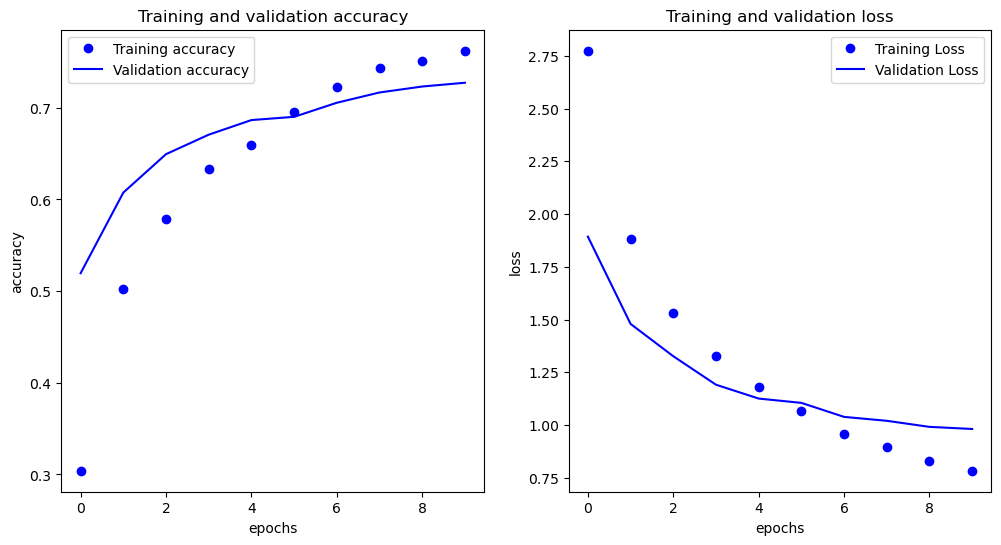

In [56]:
plot_loss_acc(history_effnet)

### Data augmentation

In [57]:
# with data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),  # Légère rotation pour simuler des variations d'angle
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # Translation modérée pour des déplacements légers
    tf.keras.layers.RandomZoom(0.1),  # Zoom léger pour varier l'échelle
    tf.keras.layers.RandomBrightness(0.1),  # Ajustement léger de la luminosité
    tf.keras.layers.Rescaling(1./255)  # Normalisation
])

model_effnet_v2=tf.keras.models.Sequential([
    base_model_effnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='softmax')
])

In [58]:
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_effnet_v2
])


In [59]:
model_with_aug.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


La data augmentation risque de dénaturer les spécificités du style artistique de chaque peintre, comme les couleurs, la composition ou les textures, ce qui rend difficile l'apprentissage des traits distinctifs propres à chaque artiste. En modifiant ces caractéristiques uniques, elle peut uniformiser les données et réduire les performances du modèle pour la classification.

=> C'est pourcela qu'on considère que la data augmentation n'est pas une bonne approche dans le cadre de ce projet.